In [1]:
import numpy as np
import os, sys
sys.path.append('environments/')
from generate_pendulum_tuples import tuples
import numpy as np
import pandas as pd
import random
import pickle, os, csv, math, time, joblib
from joblib import Parallel, delayed
import datetime as dt
from datetime import date, datetime, timedelta
from collections import Counter
import copy as cp
import tqdm
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import log_loss, f1_score, precision_score, recall_score, accuracy_score
#import matplotlib.pyplot as plt
#import matplotlib.ticker as ticker
import collections 
#import shap
import seaborn as sns
import random
from sklearn.linear_model import LinearRegression
np.seterr(all="ignore")
import matplotlib.pyplot as plt
import tqdm
import math
import statsmodels.api as sm
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import json
import util as util_fqi
import sys
sys.path.append('models/')
from lmmfqi import LMMFQIagent
from fqi import FQIagent
from cfqi import CFQIagent
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
from os.path import join as pjoin
from pendulum import PendulumEnv

# Generate pendulum data

In [2]:
bg_tuples, fg_tuples = tuples(n_trajectories=10)
all_tuples = bg_tuples + fg_tuples
random.shuffle(all_tuples)
split = 0.8
train_tuples = all_tuples[:int(split*len(all_tuples))]
test_tuples = all_tuples[int(split*len(all_tuples)):]

# Train Agents

N actions:  5
Learning policy
Run 0 :
Initialize: get batch, set initial Q
Learn policy
Opta:  [-2  0  1 ...  1  1 -2]
Optimization terminated successfully.
         Current function value: 1.048829
         Iterations: 344
         Function evaluations: 14186
         Gradient evaluations: 346


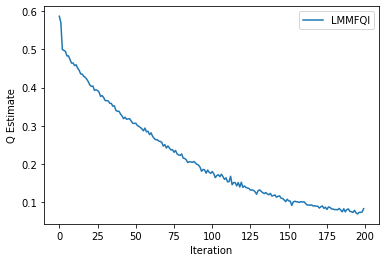

In [24]:
lmm_agent = LMMFQIagent(train_tuples=train_tuples, test_tuples=test_tuples, estimator='gbm', gamma=0.99, state_dim=3, batch_size=1600, iters=200)
Q_dist = lmm_agent.runFQI(repeats=1)
plt.plot(Q_dist, label= "LMMFQI")
plt.xlabel("Iteration")
plt.ylabel("Q Estimate")
plt.legend()
plt.show()

N actions:  5
Learning policy
Run 0 :
Initialize: get batch, set initial Q
Learn policy
Opta:  [-2  0  2 ...  2  2 -2]
Fit score:  0.5


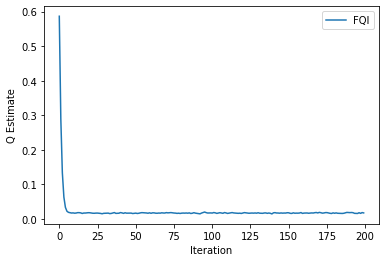

In [25]:
fqi_agent = FQIagent(train_tuples=train_tuples, test_tuples=test_tuples, state_dim=3, gamma=0.5, batch_size=1600, iters=200, estimator='gbm')
Q_dist = fqi_agent.runFQI(repeats=1)
plt.plot(Q_dist, label= "FQI")
plt.xlabel("Iteration")
plt.ylabel("Q Estimate")
plt.legend()
plt.show()

In [26]:
# Check to see if optAs are similar/same:
same = 0
total = 0
for lm, f in zip(lmm_agent.optA, fqi_agent.optA):
    total += 1
    if lm == f:
        same += 1
print("LMMFQI and FQI pick the same action: " + str(same/total))

LMMFQI and FQI pick the same action: 0.461875


/Users/aishwaryamandyam/anaconda3/envs/research/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/aishwaryamandyam/anaconda3/envs/research/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Action')

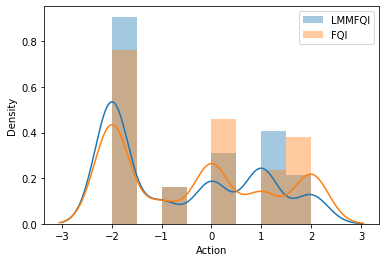

In [31]:
sns.distplot(lmm_agent.optA, label='LMMFQI')
sns.distplot(fqi_agent.optA, label='FQI')
plt.legend()
plt.xlabel("Action")

<AxesSubplot:>

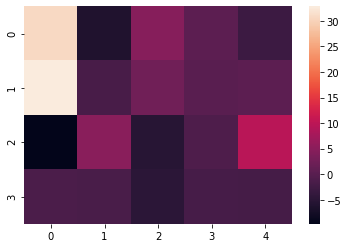

In [35]:
sns.heatmap(lmm_agent.piE.coefs_shared)

<AxesSubplot:>

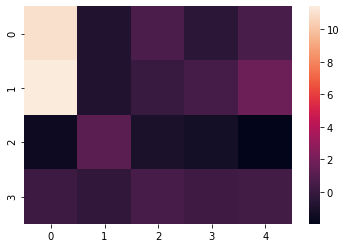

In [36]:
sns.heatmap(lmm_agent.piE.coefs_fg)

# Validation

In [7]:
def validate_agent(pend, ds='foreground', plot='action'):
        algos = ['fqi', 'lmmfqi', 'oracle', 'random']
        val_rewards = {}
        alg_actions = {}
        for alg in algos:
            val_rewards[alg] = []
            alg_actions[alg] = []
        
        for alg in algos:
            print("Alg: ", alg)
            pend.reset()
            
            for i in range(100):
                s = pend._get_obs().reshape((1, -1))
#                 print(pend.state)
                if alg == 'fqi':
                    # FQI agent\n",
                    fqi_action = fqi_agent.piE.predict(s)
                    #fqi_action = np.rint(fqi_action)
                    alg_actions['fqi'].append(fqi_action[0])
                    ns, cost, _, _ = pend.step(fqi_action)
                    val_rewards['fqi'].append(cost/10)
                    s = ns
                elif alg == 'lmmfqi':
                    # LMMFQI agent
                    if ds == 'foreground':
                        group = [1]
                    else:
                        group = [0]
#                     lmmfqi_action = lmm_agent.piE.predict(s)
                    lmmfqi_action = lmm_agent.piE.predict(s, group)
#                     lmmfqi_action = np.rint(lmmfqi_action)
                    
                    alg_actions['lmmfqi'].append(lmmfqi_action[0])
                    ns, cost, _, _ = pend.step(lmmfqi_action)
                    val_rewards['lmmfqi'].append(cost/10)
                elif alg == 'random':
                   # Random action
                    random_action = pend.action_space.sample()
                    random_action = np.rint(random_action)
                    alg_actions['random'].append(random_action[0])
                    ns, cost, _, _ = pend.step(random_action)
                    val_rewards['random'].append(cost)
                elif alg == 'oracle':
                    # Oracle
                    best_reward = None
                    best_ns = None
                    best_action = None
                    actions = [-2, -1, 0, 1, 2]
                    for j, a in enumerate(actions):
                        a = np.asarray([a])
                        ns, cost, _, _ = pend.step(a)
                        if best_reward is None or cost > best_reward:
                            best_reward = cost
                            best_ns = ns
                            best_action = a
                    alg_actions['oracle'].append(best_action[0])
                    val_rewards['oracle'].append(best_reward)
                    ns = best_ns
                else:
                    raise Exception("Invalid algorithm selected")

        #plt.title(\"Cumulative Reward for ds: \" + str(ds))\n",
        plt.xlabel("Step")
        
        x = [i for i in range(100)]
        rewards_fqi = util_fqi.cumulative_reward(val_rewards['fqi'])
        rewards_lmmfqi = util_fqi.cumulative_reward(val_rewards['lmmfqi'])
        rewards_oracle = util_fqi.cumulative_reward(val_rewards['oracle'])
        rewards_random = util_fqi.cumulative_reward(val_rewards['random'])
        if plot == 'reward':
            plt.plot(x, rewards_fqi, label="FQI", alpha=0.7)
            plt.plot(x, rewards_lmmfqi, label='LMMFQI', alpha=0.7)
#             plt.plot(x, rewards_oracle, label='Oracle')
#             plt.plot(x, rewards_random, label='Random', alpha=0.7)
            plt.ylabel("Cumulative Reward")
        else:
            plt.plot(x, alg_actions['fqi'], label="FQI", alpha=0.7)
            plt.plot(x, alg_actions['lmmfqi'], label='LMMFQI', alpha=0.7)
#             plt.plot(x, alg_actions['oracle'], label='Oracle')
#             plt.plot(x, alg_actions['random'], label='Random', alpha=0.7)
            plt.ylabel("Action")
        plt.legend()
        plt.show()

Alg:  fqi
Alg:  lmmfqi
Alg:  oracle
Alg:  random


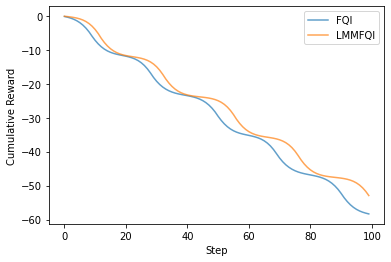

In [18]:
# Foreground Environment
pend = PendulumEnv(m=5.0)
validate_agent(pend, ds='foreground', plot='reward')

Alg:  fqi
Alg:  lmmfqi
Alg:  oracle
Alg:  random


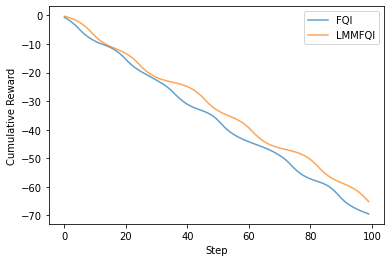

In [19]:
# Background Environment
pend = PendulumEnv(m=1.0)
validate_agent(pend, ds='background', plot='reward')